In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import torchvision.datasets as data
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from utils import AverageMeter, ProgressMeter

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.con_base = models.vgg16(pretrained=True).features
        set_trainable = False
        for param_name, param in self.con_base.named_parameters():
            if param_name == '24.weight':
                set_trainable = True
            param.requires_grad = set_trainable
        self.fc1 = nn.Linear(8192, 256)
        self.fc2 = nn.Linear(256, 1)
    
    def forward(self, x):
        batch_size, C, H, W = x.size()
        x = self.con_base(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
model = Model().to(device)

In [5]:
summary(model, input_size=(3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [6]:
base_dir = r"/data/bitt/wzq/wzq/python-deep-learning/data/cats_and_dogs_small"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
train_transform = transforms.Compose([transforms.RandomAffine(40, translate=(0, 0.3), scale=(0.8, 1.2), shear=(-30, 30), resample=Image.NEAREST),
#                                        transforms.RandomRotation(40),
#                                        transforms.RandomAffine(degrees=0, scale=(0.2, 0.3)),
#                                        transforms.RandomAffine(degrees=0, shear=(0.2, 0.2)),
                                       transforms.Resize((150, 150)),
                                       transforms.RandomHorizontalFlip(), 
#                                        transforms.RandomVerticalFlip(),
                                       transforms.ToTensor(),
                                       ])
test_transform = transforms.Compose([transforms.Resize((150, 150)),
                                     transforms.ToTensor()])

In [8]:
train_data = data.ImageFolder(train_dir, train_transform)
val_data = data.ImageFolder(validation_dir, test_transform)

In [9]:
train_dataloader = DataLoader(train_data, batch_size=20, shuffle=True, num_workers=20)
val_dataloader = DataLoader(val_data, batch_size=20)

In [10]:
criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)  # 更改了一下alpha

In [11]:
def train(model, train_loader, device, criteria, optimizer):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(train_loader), losses, accuracy)
    model.train()
    for i, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device).float().view(-1, 1)
        output = model(input)
        loss = criteria(output, target)
        losses.update(loss.item(), input.size(0))
        pre = output > 0.5
        predict = torch.zeros_like(pre).float()
        predict[pre] = 1.0
        correct = predict.eq(target.view_as(predict)).sum().item() / input.size(0)
        accuracy.update(correct, input.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            progress.pr2int(i)
    return losses.avg, accuracy.avg

In [12]:
def evaluate(model, val_loader, device, criteria):
    losses = AverageMeter("Loss", ':.4e')
    accuracy = AverageMeter("Acc", ":6.2f")
    progress = ProgressMeter(len(val_loader), losses, accuracy)
    model.eval()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            input = input.to(device)
            target = target.to(device).float().view(-1, 1)
            output = model(input)
            loss = criteria(output, target)
            losses.update(loss.item(), input.size(0))
            pre = output > 0.5
            predict = torch.zeros_like(pre).float()
            predict[pre] = 1.0
            acc = predict.eq(target.view_as(predict)).sum().item() / input.size(0)
            accuracy.update(acc, input.size(0))
        return losses.avg, accuracy.avg

In [13]:
train_loss = []
train_acc = []
val_losses = []
val_acces = []
for i in range(100):
    print("Epoch: ", i)
    loss, acc = train(model, train_dataloader, device, criteria, optimizer)
    val_loss, val_acc = evaluate(model, val_dataloader, device, criteria)
    print("val loss: {}, val acc: {}".format(val_loss, val_acc))
    train_loss.append(loss)
    train_acc.append(acc)
    val_losses.append(val_loss)
    val_acces.append(val_acc)

Epoch:  0
[  0/100]	Loss 6.9216e-01 (6.9216e-01)	Acc   0.50 (  0.50)
[ 10/100]	Loss 4.4592e-01 (5.7522e-01)	Acc   0.75 (  0.68)
[ 20/100]	Loss 1.2393e-01 (4.3254e-01)	Acc   0.90 (  0.78)
[ 30/100]	Loss 2.2584e-01 (3.9866e-01)	Acc   0.90 (  0.81)
[ 40/100]	Loss 1.2978e-01 (3.6432e-01)	Acc   1.00 (  0.84)
[ 50/100]	Loss 1.5753e-01 (3.3029e-01)	Acc   0.85 (  0.85)
[ 60/100]	Loss 1.7593e-01 (3.2916e-01)	Acc   0.85 (  0.85)
[ 70/100]	Loss 3.9739e-01 (3.1669e-01)	Acc   0.80 (  0.85)
[ 80/100]	Loss 2.5455e-01 (3.0315e-01)	Acc   0.90 (  0.86)
[ 90/100]	Loss 2.4589e-01 (2.9544e-01)	Acc   0.85 (  0.86)
val loss: 0.12618573996704072, val acc: 0.943
Epoch:  1
[  0/100]	Loss 6.8419e-02 (6.8419e-02)	Acc   1.00 (  1.00)
[ 10/100]	Loss 9.2958e-02 (1.6511e-01)	Acc   0.95 (  0.93)
[ 20/100]	Loss 1.4973e-01 (1.6131e-01)	Acc   0.95 (  0.93)
[ 30/100]	Loss 1.9973e-01 (1.7597e-01)	Acc   0.90 (  0.93)
[ 40/100]	Loss 1.6553e-01 (1.9327e-01)	Acc   0.90 (  0.92)
[ 50/100]	Loss 1.7030e-01 (2.0320e-01)	Acc   0.90

[ 80/100]	Loss 5.5292e-02 (8.9304e-02)	Acc   0.95 (  0.96)
[ 90/100]	Loss 1.9003e-01 (8.9654e-02)	Acc   0.95 (  0.96)
val loss: 0.10105231937217468, val acc: 0.963
Epoch:  13
[  0/100]	Loss 2.5177e-02 (2.5177e-02)	Acc   1.00 (  1.00)
[ 10/100]	Loss 2.7244e-02 (7.4707e-02)	Acc   1.00 (  0.98)
[ 20/100]	Loss 3.0380e-02 (7.2197e-02)	Acc   1.00 (  0.98)
[ 30/100]	Loss 7.3899e-02 (7.9882e-02)	Acc   0.95 (  0.97)
[ 40/100]	Loss 4.7727e-03 (7.5503e-02)	Acc   1.00 (  0.97)
[ 50/100]	Loss 1.3635e-01 (7.5159e-02)	Acc   0.95 (  0.97)
[ 60/100]	Loss 6.4410e-03 (7.4459e-02)	Acc   1.00 (  0.97)
[ 70/100]	Loss 2.1952e-02 (7.0456e-02)	Acc   1.00 (  0.97)
[ 80/100]	Loss 6.5393e-02 (7.3318e-02)	Acc   0.95 (  0.97)
[ 90/100]	Loss 1.5597e-01 (7.4328e-02)	Acc   0.90 (  0.97)
val loss: 0.07505108076191391, val acc: 0.975
Epoch:  14
[  0/100]	Loss 4.6875e-02 (4.6875e-02)	Acc   1.00 (  1.00)
[ 10/100]	Loss 1.6335e-02 (7.6646e-02)	Acc   1.00 (  0.97)
[ 20/100]	Loss 2.3725e-02 (6.9432e-02)	Acc   1.00 (  0.97)
[

[ 50/100]	Loss 4.4070e-02 (4.7090e-02)	Acc   0.95 (  0.99)
[ 60/100]	Loss 1.4443e-03 (4.3157e-02)	Acc   1.00 (  0.99)
[ 70/100]	Loss 1.0799e-02 (4.2466e-02)	Acc   1.00 (  0.99)
[ 80/100]	Loss 5.1367e-03 (4.2466e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 4.0400e-02 (4.1009e-02)	Acc   1.00 (  0.99)
val loss: 0.18767693513602807, val acc: 0.959
Epoch:  26
[  0/100]	Loss 8.9172e-04 (8.9172e-04)	Acc   1.00 (  1.00)
[ 10/100]	Loss 3.3460e-02 (4.3310e-02)	Acc   1.00 (  0.99)
[ 20/100]	Loss 4.8258e-02 (4.3432e-02)	Acc   1.00 (  0.99)
[ 30/100]	Loss 3.1512e-02 (4.9239e-02)	Acc   1.00 (  0.98)
[ 40/100]	Loss 3.0562e-01 (5.2579e-02)	Acc   0.85 (  0.98)
[ 50/100]	Loss 4.6553e-02 (4.6152e-02)	Acc   0.95 (  0.98)
[ 60/100]	Loss 7.3578e-02 (4.7668e-02)	Acc   0.95 (  0.98)
[ 70/100]	Loss 8.7149e-02 (5.2396e-02)	Acc   0.95 (  0.98)
[ 80/100]	Loss 1.7646e-01 (5.2127e-02)	Acc   0.95 (  0.98)
[ 90/100]	Loss 5.1196e-02 (5.2949e-02)	Acc   0.95 (  0.98)
val loss: 0.08469451434822986, val acc: 0.971
Epoch:  27
[

[ 20/100]	Loss 1.2817e-02 (3.1233e-02)	Acc   1.00 (  0.99)
[ 30/100]	Loss 6.5661e-02 (3.0415e-02)	Acc   0.95 (  0.99)
[ 40/100]	Loss 1.6839e-03 (2.8915e-02)	Acc   1.00 (  0.99)
[ 50/100]	Loss 5.0334e-02 (4.0942e-02)	Acc   1.00 (  0.99)
[ 60/100]	Loss 1.0480e-01 (3.9972e-02)	Acc   0.95 (  0.99)
[ 70/100]	Loss 1.7813e-04 (4.0103e-02)	Acc   1.00 (  0.99)
[ 80/100]	Loss 2.0278e-03 (3.8111e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 8.6307e-03 (3.7195e-02)	Acc   1.00 (  0.99)
val loss: 0.15808315416847107, val acc: 0.961
Epoch:  39
[  0/100]	Loss 2.4166e-03 (2.4166e-03)	Acc   1.00 (  1.00)
[ 10/100]	Loss 1.3145e-01 (2.3265e-02)	Acc   0.95 (  0.99)
[ 20/100]	Loss 1.3406e-05 (1.9268e-02)	Acc   1.00 (  0.99)
[ 30/100]	Loss 9.2325e-02 (4.1958e-02)	Acc   0.95 (  0.98)
[ 40/100]	Loss 8.7510e-02 (5.5919e-02)	Acc   0.95 (  0.97)
[ 50/100]	Loss 2.0517e-02 (5.8048e-02)	Acc   1.00 (  0.98)
[ 60/100]	Loss 2.5165e-02 (6.1211e-02)	Acc   1.00 (  0.98)
[ 70/100]	Loss 3.1231e-02 (5.7331e-02)	Acc   1.00 (  0.98)

val loss: 0.11340075290081586, val acc: 0.967
Epoch:  51
[  0/100]	Loss 7.0026e-03 (7.0026e-03)	Acc   1.00 (  1.00)
[ 10/100]	Loss 3.2761e-02 (3.4710e-02)	Acc   1.00 (  0.98)
[ 20/100]	Loss 1.8638e-02 (2.1763e-02)	Acc   1.00 (  0.99)
[ 30/100]	Loss 4.5549e-02 (2.1873e-02)	Acc   1.00 (  0.99)
[ 40/100]	Loss 2.3302e-01 (2.5046e-02)	Acc   0.95 (  0.99)
[ 50/100]	Loss 1.1142e-02 (2.1999e-02)	Acc   1.00 (  0.99)
[ 60/100]	Loss 5.5183e-04 (1.9765e-02)	Acc   1.00 (  0.99)
[ 70/100]	Loss 1.4497e-01 (2.7347e-02)	Acc   0.95 (  0.99)
[ 80/100]	Loss 2.6665e-02 (3.0236e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 1.4377e-02 (3.1169e-02)	Acc   1.00 (  0.99)
val loss: 0.1499151464040915, val acc: 0.963
Epoch:  52
[  0/100]	Loss 5.0644e-03 (5.0644e-03)	Acc   1.00 (  1.00)
[ 10/100]	Loss 1.5146e-02 (5.7202e-02)	Acc   1.00 (  0.98)
[ 20/100]	Loss 9.9176e-03 (4.7256e-02)	Acc   1.00 (  0.99)
[ 30/100]	Loss 4.5856e-03 (4.1297e-02)	Acc   1.00 (  0.99)
[ 40/100]	Loss 6.1104e-02 (4.4457e-02)	Acc   1.00 (  0.99)
[ 

[ 70/100]	Loss 1.4463e-03 (3.6224e-02)	Acc   1.00 (  0.99)
[ 80/100]	Loss 3.4572e-03 (3.5845e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 1.4105e-03 (3.5615e-02)	Acc   1.00 (  0.99)
val loss: 0.09901743965128844, val acc: 0.97
Epoch:  64
[  0/100]	Loss 1.9613e-02 (1.9613e-02)	Acc   1.00 (  1.00)
[ 10/100]	Loss 2.4074e-03 (7.6100e-03)	Acc   1.00 (  1.00)
[ 20/100]	Loss 2.2523e-01 (2.6459e-02)	Acc   0.85 (  0.99)
[ 30/100]	Loss 3.9620e-02 (4.7277e-02)	Acc   1.00 (  0.98)
[ 40/100]	Loss 1.6998e-03 (4.6945e-02)	Acc   1.00 (  0.98)
[ 50/100]	Loss 1.2369e-01 (4.3771e-02)	Acc   0.95 (  0.98)
[ 60/100]	Loss 2.8350e-02 (4.2121e-02)	Acc   1.00 (  0.98)
[ 70/100]	Loss 3.8680e-02 (3.8323e-02)	Acc   1.00 (  0.99)
[ 80/100]	Loss 5.8236e-03 (4.1985e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 4.1533e-02 (3.9303e-02)	Acc   0.95 (  0.99)
val loss: 0.1232369550102237, val acc: 0.972
Epoch:  65
[  0/100]	Loss 2.7313e-05 (2.7313e-05)	Acc   1.00 (  1.00)
[ 10/100]	Loss 1.6486e-01 (2.3122e-02)	Acc   0.90 (  0.99)
[ 2

[ 40/100]	Loss 6.6468e-03 (2.3565e-02)	Acc   1.00 (  0.99)
[ 50/100]	Loss 7.9473e-02 (2.2482e-02)	Acc   0.95 (  0.99)
[ 60/100]	Loss 4.9591e-03 (2.5384e-02)	Acc   1.00 (  0.99)
[ 70/100]	Loss 9.0943e-03 (2.3952e-02)	Acc   1.00 (  0.99)
[ 80/100]	Loss 9.5537e-02 (2.4085e-02)	Acc   0.95 (  0.99)
[ 90/100]	Loss 1.7733e-03 (2.3561e-02)	Acc   1.00 (  0.99)
val loss: 0.10441886214186524, val acc: 0.966
Epoch:  77
[  0/100]	Loss 2.5494e-02 (2.5494e-02)	Acc   1.00 (  1.00)
[ 10/100]	Loss 1.1021e-03 (5.0008e-03)	Acc   1.00 (  1.00)
[ 20/100]	Loss 5.8864e-02 (1.1479e-02)	Acc   0.95 (  1.00)
[ 30/100]	Loss 3.0544e-03 (1.2580e-02)	Acc   1.00 (  1.00)
[ 40/100]	Loss 1.0471e-03 (1.0743e-02)	Acc   1.00 (  1.00)
[ 50/100]	Loss 2.4082e-03 (1.0936e-02)	Acc   1.00 (  1.00)
[ 60/100]	Loss 2.6641e-04 (1.1216e-02)	Acc   1.00 (  1.00)
[ 70/100]	Loss 2.2350e-01 (1.7904e-02)	Acc   0.95 (  0.99)
[ 80/100]	Loss 4.2505e-03 (2.2849e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 4.2918e-02 (2.3621e-02)	Acc   1.00 (  0.99)

[ 10/100]	Loss 4.5133e-03 (4.3914e-02)	Acc   1.00 (  0.98)
[ 20/100]	Loss 1.3422e-01 (3.2109e-02)	Acc   0.95 (  0.99)
[ 30/100]	Loss 3.5966e-03 (4.0851e-02)	Acc   1.00 (  0.99)
[ 40/100]	Loss 2.6404e-02 (3.8173e-02)	Acc   1.00 (  0.99)
[ 50/100]	Loss 2.2741e-01 (4.1982e-02)	Acc   0.95 (  0.99)
[ 60/100]	Loss 4.3597e-03 (3.9765e-02)	Acc   1.00 (  0.99)
[ 70/100]	Loss 8.7068e-03 (3.9355e-02)	Acc   1.00 (  0.99)
[ 80/100]	Loss 2.0393e-02 (3.9636e-02)	Acc   1.00 (  0.99)
[ 90/100]	Loss 2.6244e-02 (4.5203e-02)	Acc   1.00 (  0.99)
val loss: 0.10044967132525925, val acc: 0.966
Epoch:  90
[  0/100]	Loss 3.4155e-03 (3.4155e-03)	Acc   1.00 (  1.00)
[ 10/100]	Loss 9.8442e-04 (1.0175e-02)	Acc   1.00 (  1.00)
[ 20/100]	Loss 1.2118e-02 (1.7722e-02)	Acc   1.00 (  1.00)
[ 30/100]	Loss 3.6728e-03 (1.9315e-02)	Acc   1.00 (  0.99)
[ 40/100]	Loss 8.6348e-05 (2.1061e-02)	Acc   1.00 (  0.99)
[ 50/100]	Loss 1.3934e-02 (2.4242e-02)	Acc   1.00 (  0.99)
[ 60/100]	Loss 2.0902e-03 (2.3220e-02)	Acc   1.00 (  0.99)

In [14]:
epoches = range(1, len(train_acc) + 1)

In [15]:
import matplotlib.pyplot as plt

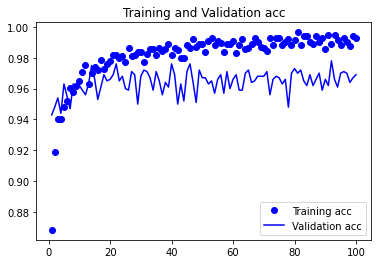

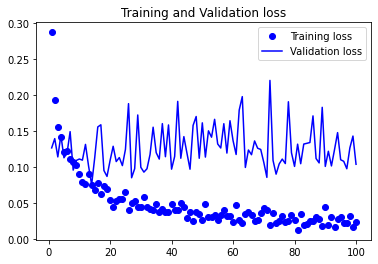

In [17]:
plt.plot(epoches, train_acc, 'bo', label="Training acc")
plt.plot(epoches, val_acces, 'b', label='Validation acc')
plt.title("Training and Validation acc")
plt.legend()
plt.figure()
plt.plot(epoches, train_loss, 'bo', label="Training loss")
plt.plot(epoches, val_losses, 'b', label='Validation loss')
plt.title("Training and Validation loss")
plt.legend()
plt.show()